# Setup



## Colab setup
---------- Start of generic setup code to get kaggle credentials login and data to work with. Copied much from Workshop 2 ----------

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
!pip install -U -q scikeras
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [2]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

https://drive.google.com/file/d/1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x

In [3]:
# GET data from file I've uploaded to my drive. Use your own kaggle.json and google auth logins etc
downloaded = drive.CreateFile({"id": "1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x"})
downloaded.GetContentFile("predict-energy-consumption.zip")

In [4]:
!unzip predict-energy-consumption.zip

!ls
!mkdir data
!mv *.csv data/

Archive:  predict-energy-consumption.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               
predict-energy-consumption.zip	sample_submission.csv  train.csv
sample_data			test.csv


In [5]:
from google.colab import files

files.upload()
# upload your kaggle.json file

Saving kaggle.json to kaggle.json


Processing data from the source.

In [6]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [7]:
# GENERIC SUBMIT FUNCTION (uncomment when you want to submit)

# submission = pd.DataFrame(
#    {'key': test.key, 'fare_amount': val_predictions},
#    columns = ['key', 'fare_amount'])
# submission.to_csv('submission.csv', index = False)


#!kaggle competitions submit -c predict-electricity-consumption -f submission.csv -m "[TEAM NAME] Submission"

## Libraries setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data exploration

### Modification functions

In [103]:
def replaceNanWithZero(test, train, labels):
    train_labels = labels.replace(np.nan, 0.0)

    for col in train.columns:
        train[col] = train[col].replace(np.nan, 0.0)

    for col in test.columns:
        test[col] = test[col].replace(np.nan, 0.0)

    return test, train, train_labels

In [104]:
# PCA to get a lesser number of features, then going to feed into basic nn see what we can do
from sklearn.decomposition import PCA


def PCA_Performance(train, test):
    variance = [0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

    for var in variance:
        pca = PCA(n_components=var)
        pca.fit(train)
        transformed_Train = pca.transform(train)
        # transformed_Test = pca.transform(test)
        print(
            f"Retained {var} of variance with {len(transformed_Train.T)} number of features"
        )

In [105]:
def month_to_season(month: int) -> str:
    assert 1 <= month < 13
    if 3 <= month < 6:
        return "spring"
    elif 6 <= month < 9:
        return "summer"
    elif 9 <= month < 12:
        return "autumn"
    else:
        return "winter"

In [157]:
def cast_types(df: pd.DataFrame) -> pd.DataFrame:
    
    # Cast time, respect timezone
    df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("Europe/Tallinn")

    # Cast remaining columns
    df = df.astype(
        {
            "temp": "float32",
            "dwpt": "float32",
            "rhum": "int32",
            "prcp": "float32",
            "snow": "float32",
            "wdir": "int32",
            "wspd": "float32",
            "wpgt": "float32",
            "pres": "float32",
            "coco": "category",
            "el_price": "float32",
        }
    )
    
    # Change coco categories from float to int representation
    new_categories = [int(category) for category in df["coco"].cat.categories]
    
    df["coco"] = df["coco"].cat.rename_categories(new_categories)


    return df

In [107]:
def explode_datetime(
    df: pd.DataFrame, datetime_column: str, without_prefix: bool = False
) -> pd.DataFrame:

    prefix = "" if without_prefix else f"{datetime_column}_"

    if f"{prefix}year" in df.columns:
        print(f"Column {prefix}year already exists")
        return df

    date_info = pd.DataFrame(
        data=[
            [x.year, x.month, x.day, x.hour, x.weekday()] for x in df[datetime_column]
        ],
        columns=[
            f"{prefix}year",
            f"{prefix}month",
            f"{prefix}day",
            f"{prefix}hour",
            f"{prefix}weekday",
        ],
    ).astype(np.int32)

    df = pd.concat([df.reset_index(), date_info], axis=1).set_index("index")

    return df

## Exploration

In [158]:
# Here we can split into train/test for verification while we train whatever works)
train = pd.read_csv("data/train.csv")
train_labels = train["consumption"]  # y vals in this case are concumption
# GIVEN time is a string we just gonna drop that mfer, cbf processing it etc

test = pd.read_csv("data/test.csv")

# Have to predict consumption for these values. Consumption unkown.
# At this point should have a train and test without Nan values:)

In [159]:
train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


## Preprocessing

### First look

In [160]:
train.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
count,8592.000000,8592.000000,8592.000000,2159.000000,119.000000,8592.000000,8592.000000,8592.000000,8592.000000,8396.000000,8592.000000,8590.000000
mean,6.744204,2.486767,77.013617,0.056647,78.319328,201.564246,9.156355,20.869681,1013.229423,4.902930,0.160844,1.046364
std,9.257806,8.184391,17.520566,0.384586,63.129130,87.792064,4.826976,9.956558,12.592944,4.958744,0.120034,1.095114
min,-26.100000,-28.700000,20.000000,0.000000,0.000000,0.000000,0.000000,2.900000,962.600000,1.000000,0.000070,0.000000
25%,0.400000,-2.900000,66.000000,0.000000,20.000000,150.000000,7.200000,13.000000,1006.500000,2.000000,0.092820,0.363000
50%,6.200000,1.900000,83.000000,0.000000,60.000000,210.000000,7.200000,18.500000,1014.700000,3.000000,0.136440,0.811000
75%,13.225000,9.000000,91.000000,0.000000,130.000000,270.000000,10.800000,27.800000,1020.700000,5.000000,0.199845,1.366000
max,31.400000,20.900000,100.000000,7.900000,220.000000,360.000000,31.700000,63.000000,1047.500000,25.000000,4.000000,10.381000


In [161]:
train.isna().sum()

time              0
temp              0
dwpt              0
rhum              0
prcp           6433
snow           8473
wdir              0
wspd              0
wpgt              0
pres              0
coco            196
el_price          0
consumption       2
dtype: int64

Most missing values are for snow and precipitation

For snow it is quite a lot of data

- Delete it?
- Impute it with zero when temprature is over 0?
    - How many is left?
    
For coco it is a problem, I think this will be useful information for model

- Are the NaNs sparsely distributed?
    - If so, we can impute from the most common value in +- 2 or 3 values before and after (timeseries)f
- Can the information be found elsewhere?
    - Where is the model house located?

To the precipitation

- That is a huge problem
    - I think this data might be valuable
    - To many values missing for intelligent imputation
- Either find external source, remove it all, or impute with pure zeros
- Even if we delete it a lot of the information is stored in humidity
    - Or is it?

In [162]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8592 entries, 0 to 8591
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8592 non-null   object 
 1   temp         8592 non-null   float64
 2   dwpt         8592 non-null   float64
 3   rhum         8592 non-null   float64
 4   prcp         2159 non-null   float64
 5   snow         119 non-null    float64
 6   wdir         8592 non-null   float64
 7   wspd         8592 non-null   float64
 8   wpgt         8592 non-null   float64
 9   pres         8592 non-null   float64
 10  coco         8396 non-null   float64
 11  el_price     8592 non-null   float64
 12  consumption  8590 non-null   float64
dtypes: float64(12), object(1)
memory usage: 872.8+ KB


In [163]:
train.loc[:, ["rhum", "wdir", "coco"]].mod(1, fill_value=0).abs().sum()

rhum    0.0
wdir    0.0
coco    0.0
dtype: float64

In [164]:
# Recasting to the best suited type
train = cast_types(train)
train.dtypes

time           datetime64[ns, Europe/Tallinn]
temp                                  float32
dwpt                                  float32
rhum                                    int32
prcp                                  float32
snow                                  float32
wdir                                    int32
wspd                                  float32
wpgt                                  float32
pres                                  float32
coco                                 category
el_price                              float32
consumption                           float64
dtype: object

### Exploding time

In [165]:
# Explode datetime object into separate components
# Minutes and seconds not extracted
## Contain only zeros
## Found through correlation matrix

train = explode_datetime(train, "time", True)

# Add season category

train["season"] = train["month"].apply(lambda x: month_to_season(x)).astype("category")

train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
0,2021-09-01 00:00:00+03:00,11.2,10.3,94,NaN,NaN,320,7.2,16.700001,1012.599976,2,0.09016,0.577,2021,9,1,0,2,autumn
1,2021-09-01 01:00:00+03:00,10.7,9.6,93,NaN,NaN,320,7.2,13.000000,1012.599976,2,0.09251,0.594,2021,9,1,1,2,autumn
2,2021-09-01 02:00:00+03:00,9.9,9.0,94,NaN,NaN,320,7.2,13.000000,1012.200012,2,0.08890,0.685,2021,9,1,2,2,autumn
3,2021-09-01 03:00:00+03:00,10.0,8.4,90,NaN,NaN,330,7.2,13.000000,1011.900024,1,0.08735,1.016,2021,9,1,3,2,autumn
4,2021-09-01 04:00:00+03:00,9.0,8.1,94,NaN,NaN,300,3.6,13.000000,1011.400024,2,0.08688,0.677,2021,9,1,4,2,autumn


### Coco imputation

In [187]:
train[~train["coco"].isin([14, 15, 16, 21, 22]) & ~train["snow"].isna()]["coco"].value_counts()

4     50
1     11
2     10
3      9
7      5
5      2
6      1
8      1
17     0
23     0
22     0
21     0
20     0
19     0
18     0
13     0
16     0
15     0
14     0
12     0
10     0
9      0
25     0
Name: coco, dtype: int64

### Correlation heatmap

/var/folders/qn/lk9fg3fs0hg9v8b7zh5lbybw0000gn/T/ipykernel_64123/1694794515.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov_matrix = train.corr()


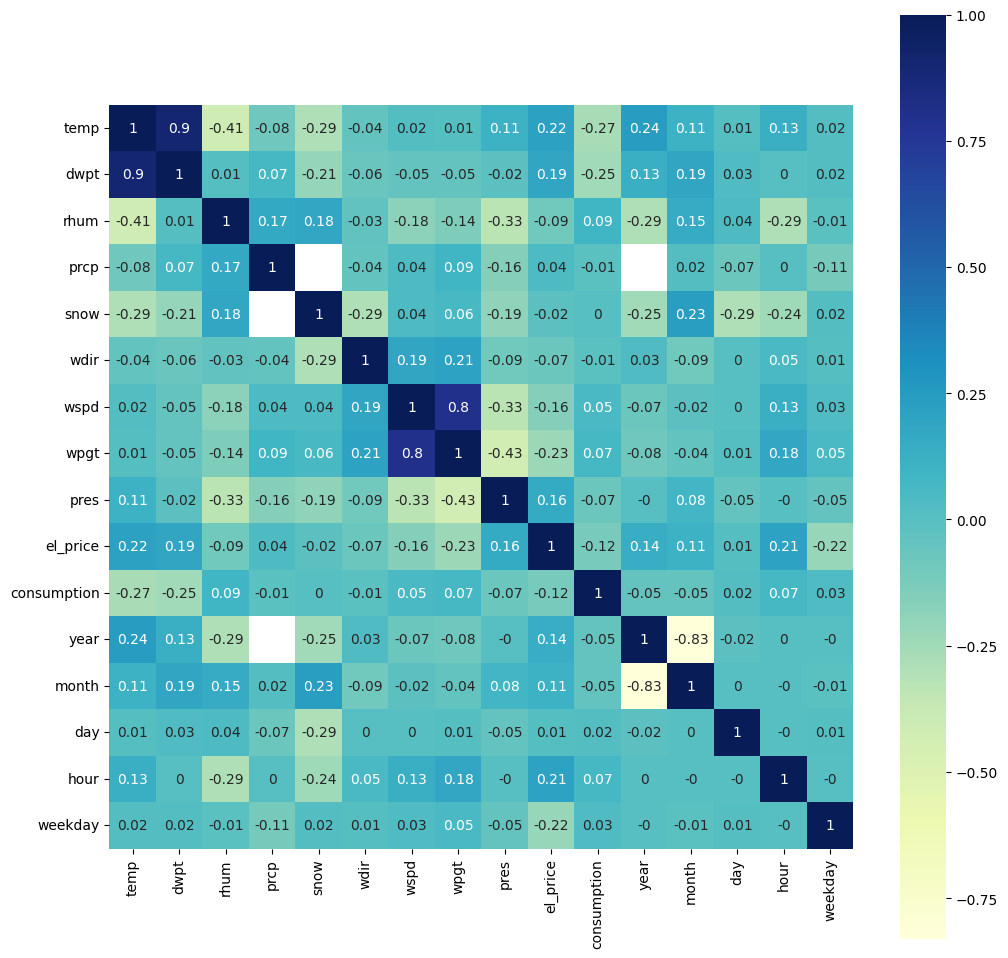

In [123]:
plt.figure(figsize=(12, 12))

cov_matrix = train.corr()
sns.heatmap(cov_matrix.round(2), annot=True, cmap="YlGnBu", square=True)
plt.show()

<AxesSubplot: >

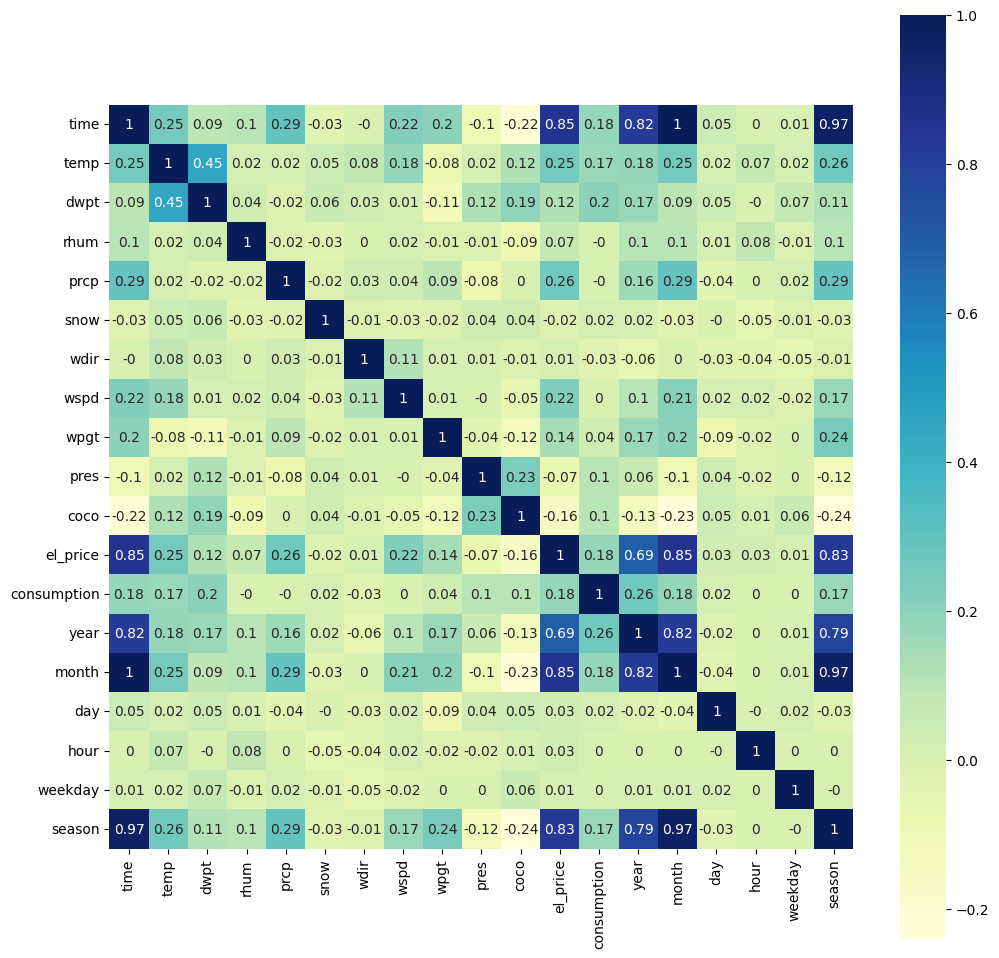

In [124]:
# Correlation method I found at https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas
# Might give completely wrong information, I do not understand its asumptions
# From what I understand it transforms categorical to nominal values and computes correlation

plt.figure(figsize=(12, 12))

train_corr = train.apply(lambda x: pd.factorize(x)[0]).corr().round(2)

sns.heatmap(train_corr, annot=True, cmap="YlGnBu", square=True)

## Data modification

In [21]:
# USE the code we wrote above
train = train.drop(["consumption"], axis=1)

train_no_time = train.drop(["time", "coco", "season"], axis=1)
test_no_time = test.drop(["time", "coco"], axis=1)
test_no_time, train_no_time, labels = replaceNanWithZero(
    test_no_time, train_no_time, train_labels
)

PCA_Performance(train_no_time, test_no_time)

Retained 0.5 of variance with 1 number of features
Retained 0.6 of variance with 1 number of features
Retained 0.75 of variance with 1 number of features
Retained 0.8 of variance with 1 number of features
Retained 0.85 of variance with 1 number of features
Retained 0.9 of variance with 2 number of features
Retained 0.95 of variance with 4 number of features
Retained 0.96 of variance with 4 number of features
Retained 0.97 of variance with 5 number of features
Retained 0.98 of variance with 6 number of features
Retained 0.99 of variance with 7 number of features
